# Importing libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
%matplotlib inline 

In [2]:
import xgboost as xgb
from xgboost import plot_tree
from xgboost import plot_importance

from sklearn.ensemble import RandomForestRegressor

from catboost import CatBoostRegressor

from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import train_test_split

# Data Extraction

In [3]:
train_df = pd.read_csv('../input/tabular-playground-series-mar-2022/train.csv')
test_df  = pd.read_csv('../input/tabular-playground-series-mar-2022/test.csv')

In [4]:
train_df.head(6)

,row_id,time,x,y,direction,congestion
0,0,1991-04-01 00:00:00,0,0,EB,70
1,1,1991-04-01 00:00:00,0,0,NB,49
2,2,1991-04-01 00:00:00,0,0,SB,24
3,3,1991-04-01 00:00:00,0,1,EB,18
4,4,1991-04-01 00:00:00,0,1,NB,60
5,5,1991-04-01 00:00:00,0,1,SB,58


In [5]:
train_df.shape

(848835, 6)

In [6]:
def missing_percent_of_column(train_set):
    nan_percent = 100*(train_set.isnull().sum()/len(train_set))
    nan_percent = nan_percent[nan_percent>0].sort_values(ascending=False).round(1)
    DataFrame = pd.DataFrame(nan_percent)
    # Rename the columns
    mis_percent_table = DataFrame.rename(columns = {0 : '% of Misiing Values'}) 
    # Sort the table by percentage of missing descending
    mis_percent = mis_percent_table
    return mis_percent

In [7]:
miss = missing_percent_of_column(train_df)
miss

,% of Misiing Values


# Exploratory Data Analysis(EDA)

<AxesSubplot:xlabel='direction', ylabel='congestion'>

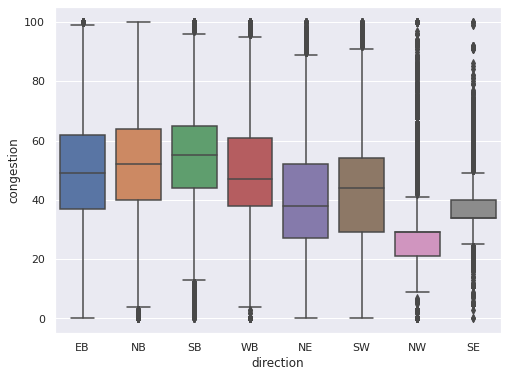

In [8]:
sns.set(rc={'figure.figsize':(8,6)})
sns.boxplot(x='direction', y='congestion', data=train_df)

<AxesSubplot:xlabel='direction', ylabel='count'>

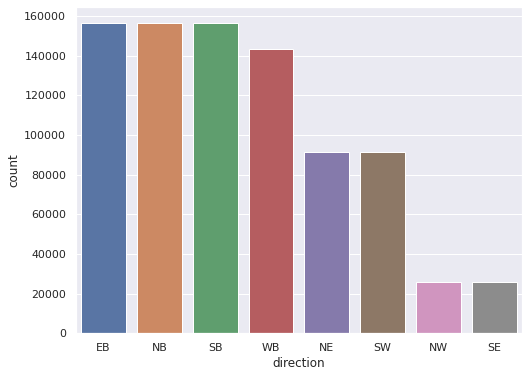

In [9]:
sns.countplot(x='direction', data=train_df)

<AxesSubplot:xlabel='congestion', ylabel='Count'>

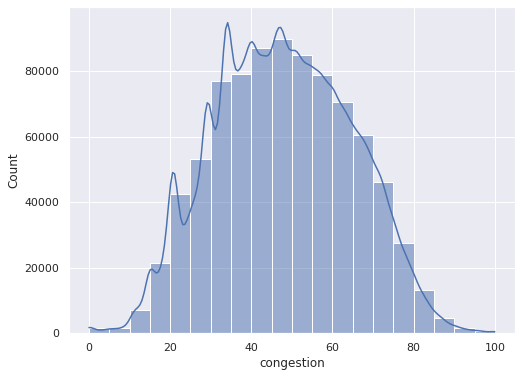

In [10]:
sns.histplot(data=train_df, x="congestion", binwidth=5,multiple="stack", kde=True, bins=20)

# Data Preparation

In [11]:
train_df['time']= pd.to_datetime(train_df['time'])
test_df['time']= pd.to_datetime(test_df['time'])

In [12]:
train_df['month'] = train_df['time'].dt.month
train_df['day'] = train_df['time'].dt.day
train_df['daytime'] = train_df['time'].dt.hour * 60 + train_df['time'].dt.minute
train_df['weekday'] = train_df['time'].dt.weekday
train_df['hour'] = train_df['time'].dt.hour
train_df['dayofyear'] = train_df['time'].dt.dayofyear

test_df['month'] = test_df['time'].dt.month
test_df['day'] = test_df['time'].dt.day
test_df['daytime'] = test_df['time'].dt.hour * 60 + test_df['time'].dt.minute
test_df['hour'] = test_df['time'].dt.hour
test_df['weekday'] = test_df['time'].dt.weekday
test_df['dayofyear'] = test_df['time'].dt.dayofyear


Removing few Outliers

In [13]:
train_df = train_df[(train_df.month != 5) | (train_df.day != 27)]
train_df = train_df[(train_df.month != 7) | (train_df.day != 4)]
train_df = train_df[(train_df.month != 9) | (train_df.day != 2)]

In [14]:
df = train_df[['hour','direction','x','y','congestion','weekday']]
df = df.groupby(by=['hour','direction','x','y','weekday'], dropna=False).mean()

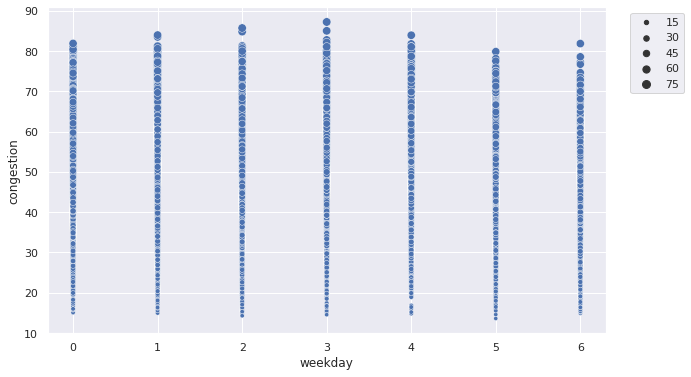

In [15]:
sns.set(rc={'figure.figsize':(10,6)})
fg=sns.scatterplot(data=df, x='weekday',y='congestion',size="congestion")
fg.legend(bbox_to_anchor= (1.15,1))

In [16]:
def isWeekDay(date):
    if date > 4:
        return 1
    else:
        return 0

In [17]:
train_df['isWeekDay'] = train_df['day'].apply(isWeekDay) 
test_df['isWeekDay'] = test_df['day'].apply(isWeekDay) 

<AxesSubplot:xlabel='direction', ylabel='hour'>

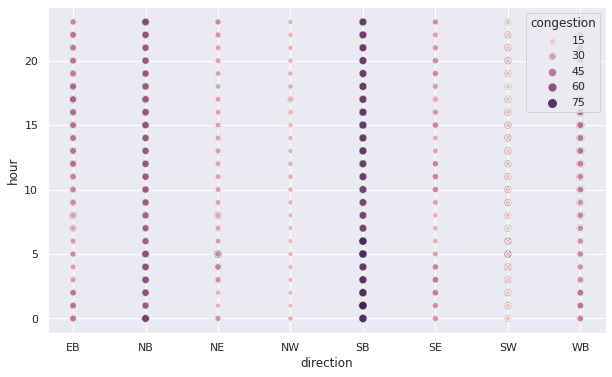

In [18]:
sns.set(rc={'figure.figsize':(10,6)})
sns.scatterplot(data=df, size="congestion",hue='congestion', y='hour', x='direction')

In [19]:
train_df = train_df.drop('time', axis='columns')
test_df = test_df.drop('time', axis='columns')

In [20]:
train_df.head(5)

,row_id,x,y,direction,congestion,month,day,daytime,weekday,hour,dayofyear,isWeekDay
0,0,0,0,EB,70,4,1,0,0,0,91,0
1,1,0,0,NB,49,4,1,0,0,0,91,0
2,2,0,0,SB,24,4,1,0,0,0,91,0
3,3,0,1,EB,18,4,1,0,0,0,91,0
4,4,0,1,NB,60,4,1,0,0,0,91,0


In [21]:
direction = {'EB':1, 'NB':2, 'SB':3, 'WB':4, 'NE':5, 'SW':6, 'NW':7,'SE':8}

train_df['direction'] = train_df['direction'].map(direction)
test_df['direction'] = test_df['direction'].map(direction)

In [22]:
test_row_id = test_df['row_id']

train_df = train_df.drop(['row_id'], axis=1)
test_df = test_df.drop(['row_id'], axis=1)

In [23]:
# Separate target from predictors
X = train_df.drop("congestion", axis=1)             
Y = train_df["congestion"]

# Break off validation set from training data
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=0)

In [24]:
X_test  = test_df.copy()

In [25]:
X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape,  X_test.shape

((667836, 10), (667836,), (166959, 10), (166959,), (2340, 10))

In [26]:
# data normalization with sklearn
from sklearn.preprocessing import MinMaxScaler

In [27]:
X_train.head(5)

,x,y,direction,month,day,daytime,weekday,hour,dayofyear,isWeekDay
152455,1,2,3,5,3,980,4,16,123,0
768315,0,3,6,9,12,1380,3,23,255,1
151064,0,1,2,5,3,560,4,9,123,0
511537,2,2,2,7,19,840,4,14,200,1
136570,0,1,3,4,30,420,1,7,120,1


In [28]:
# fit scaler on training data
norm = MinMaxScaler().fit(X_train)

# transform training data
X_train = norm.transform(X_train)

# transform testing dataabs
X_valid = norm.transform(X_valid)

# transform testing dataabs
X_test = norm.transform(X_test)

# Model Training & evaluation

**XGBoost Model**

In [29]:
xgb_model = xgb.XGBRegressor(random_state=42,n_estimators= 500,learning_rate=0.05,
                      max_depth=8,booster='gbtree',verbosity=1,tree_method = 'gpu_hist')

xgb_model.fit(X_train, Y_train,eval_metric='mae')

print("Performance on train data:", xgb_model.score(X_train, Y_train))

Performance on train data: 0.7444520071782441


In [30]:
y_pred_v = xgb_model.predict(X_valid)

In [31]:
error = mae(Y_valid, y_pred_v)
  
# display
print("Mean absolute error : " + str(error))

Mean absolute error : 6.182464525501537


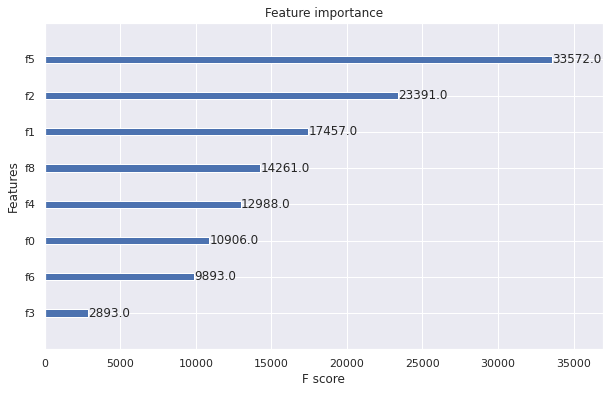

In [32]:
# plot feature importance
plot_importance(xgb_model)
plt.show()

**Random Forest**

In [33]:
regr = RandomForestRegressor(random_state=0, bootstrap=True,max_depth= 20,max_features= 'auto',min_samples_leaf= 1,n_estimators=200)
regr.fit(X_train, Y_train)

RandomForestRegressor(max_depth=20, n_estimators=200, random_state=0)

In [34]:
y_pred_v = regr.predict(X_valid)

In [35]:
error = mae(Y_valid, y_pred_v)

# display
print("Mean absolute error : " + str(error))

Mean absolute error : 5.603574267729353


**CatBoost**

In [36]:
model = CatBoostRegressor(verbose=100,early_stopping_rounds=10,max_depth=12,
    task_type='GPU',learning_rate=0.035,iterations=3000,loss_function='MAE',eval_metric= 'MAE')
model.fit(X_train, Y_train)

0:	learn: 13.5488338	total: 22.8ms	remaining: 1m 8s
100:	learn: 6.8629701	total: 1.75s	remaining: 50.1s
200:	learn: 6.6239908	total: 3.43s	remaining: 47.8s
300:	learn: 6.5428900	total: 5.49s	remaining: 49.3s
400:	learn: 6.4862736	total: 7.18s	remaining: 46.6s
500:	learn: 6.4539138	total: 8.86s	remaining: 44.2s
600:	learn: 6.4286404	total: 10.6s	remaining: 42.2s
700:	learn: 6.4105244	total: 12.3s	remaining: 40.3s
800:	learn: 6.3978170	total: 14.9s	remaining: 40.8s
900:	learn: 6.3868749	total: 16.8s	remaining: 39.2s
1000:	learn: 6.3770027	total: 18.5s	remaining: 37s
1100:	learn: 6.3695391	total: 20.3s	remaining: 34.9s
1200:	learn: 6.3632119	total: 21.9s	remaining: 32.9s
1300:	learn: 6.3577023	total: 23.6s	remaining: 30.9s
1400:	learn: 6.3539349	total: 25.4s	remaining: 29s
1500:	learn: 6.3509035	total: 27.4s	remaining: 27.4s
1600:	learn: 6.3477987	total: 29.1s	remaining: 25.5s
1700:	learn: 6.3443428	total: 30.8s	remaining: 23.6s
1800:	learn: 6.3422816	total: 32.6s	remaining: 21.7s
1900:	l

In [37]:
y_pred_v = model.predict(X_valid)

In [38]:
error = mae(Y_valid, y_pred_v)

# display
print("Mean absolute error : " + str(error))

Mean absolute error : 6.414883031655674


# Prediction

Random Forest Regressor has better performance and lower MAE compare to XGBoost on Cross Validation dataset. But when i tried uploading actual testing data, it seems XGB had better performance, so I went ahead with XGB

In [39]:
y_pred_x = xgb_model.predict(X_test)

# Submission

In [40]:
#Create a  DataFrame with the passengers ids and our prediction
submission = pd.DataFrame({'row_id':test_row_id,'congestion':y_pred_x})

In [41]:
submission.head(5)

,row_id,congestion
0,848835,49.339394
1,848836,38.047691
2,848837,42.953808
3,848838,23.042454
4,848839,68.675507


In [42]:
filename = 'submission.csv'

submission.to_csv(filename,index=False)

print('Saved file: ' + filename)

Saved file: submission.csv


# **Please upvote the notebook if you liked it.**